In [4]:
# Companies & Ceo analysis 
# This code generates Figures 1 & 2 in the paper 
#
# 1 - 11 July 2024
# marieke.van.erp@dh.huc.knaw.nl & vera.provatorova@dh.huc.knaw.nl

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import matplotlib.patches as mpatches

In [5]:
company_data = pd.read_csv('data/company_ceo_starttime.tsv', sep='\t').drop('Unnamed: 0',axis=1).drop_duplicates()
company_data['occurrence_companies'] = company_data.groupby('company.value')['company.value'].transform('size')


In [6]:
pd.to_datetime(company_data.iloc[0]['starttime.value']).tz_localize(None) #< pd.Timestamp.now()

Timestamp('2002-05-24 00:00:00')

In [7]:

# Filter out rows with invalid dates
def is_valid_date(date_str):
    try:
        date = pd.to_datetime(date_str).tz_localize(None)
        return date < pd.Timestamp.now() # we had some CEOs starting in 2100..
    except:
        return False
    
def convert_to_date(date_str):
    return pd.to_datetime(date_str).date()

company_data = company_data[company_data['starttime.value'].apply(is_valid_date)]
# print(company_data)

# Convert start time to datetime and sort by company & start time
company_data['starttime.value'] = company_data['starttime.value'].map(convert_to_date)
company_data = company_data.sort_values(by=['companyLabel.value', 'starttime.value'])

# Infer end dates
company_data['endtime.value'] = company_data.groupby('company.value')['starttime.value'].shift(-1)

# Fill NaN end dates with the current date
company_data['endtime.value'] = company_data['endtime.value'].fillna(pd.Timestamp.now().date())

# Ensure end dates are datetime
company_data['endtime.value'] = company_data['endtime.value'].map(convert_to_date)
#pd.to_datetime(company_data['endtime.value'], utc=False)


In [8]:
# Find companies with the most CEO changes (highest occurrence_companies, 95th percentile)
most_ceo_changes = company_data[company_data['occurrence_companies'] >= company_data['occurrence_companies'].quantile(0.95)]

# Find companies with no CEO changes (occurrence_companies = 1)
no_ceo_changes = company_data[company_data['occurrence_companies'] == 1]


In [9]:
first_date = most_ceo_changes['starttime.value'].min()
most_ceo_changes['start_time_in_days'] = most_ceo_changes['starttime.value'].map(lambda x: (x-first_date).days)
most_ceo_changes

/var/folders/db/zljc_tr15nbcxyj7j4frgzlr0000gn/T/ipykernel_48850/497434059.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  most_ceo_changes['start_time_in_days'] = most_ceo_changes['starttime.value'].map(lambda x: (x-first_date).days)


,ceoname.value,company.value,companyLabel.xml:lang,companyLabel.value,ceonameLabel.xml:lang,ceonameLabel.value,starttime.value,occurrence_companies,endtime.value,start_time_in_days
288,http://www.wikidata.org/entity/Q5746220,http://www.wikidata.org/entity/Q757164,en,Atlas Copco,en,Edvard Fränckel,1873-01-01,13,1887-01-01,3653
672,http://www.wikidata.org/entity/Q5932965,http://www.wikidata.org/entity/Q757164,en,Atlas Copco,en,Oscar Lamm,1887-01-01,13,1909-01-01,8766
286,http://www.wikidata.org/entity/Q5826515,http://www.wikidata.org/entity/Q757164,en,Atlas Copco,en,Gunnar Jacobsson,1909-01-01,13,1940-01-01,16801
1256,http://www.wikidata.org/entity/Q16650572,http://www.wikidata.org/entity/Q757164,en,Atlas Copco,en,Walter Wehtje,1940-01-01,13,1957-01-01,28123
951,http://www.wikidata.org/entity/Q5569202,http://www.wikidata.org/entity/Q757164,en,Atlas Copco,en,Kurt-Allan Belfrage,1957-01-01,13,1970-01-01,34333
...,...,...,...,...,...,...,...,...,...,...
48,http://www.wikidata.org/entity/Q68648,http://www.wikidata.org/entity/Q156578,en,Volkswagen Group,en,Bernd Pischetsrieder,2002-01-01,12,2007-01-01,50769
44,http://www.wikidata.org/entity/Q68355,http://www.wikidata.org/entity/Q156578,en,Volkswagen Group,en,Martin Winterkorn,2007-01-01,12,2015-09-01,52595
758,http://www.wikidata.org/entity/Q1910173,http://www.wikidata.org/entity/Q156578,en,Volkswagen Group,en,Matthias Müller,2015-09-01,12,2018-04-01,55760
588,http://www.wikidata.org/entity/Q19285388,http://www.wikidata.org/entity/Q156578,en,Volkswagen Group,en,Herbert Diess,2018-04-01,12,2022-09-01,56703


In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

def plot_gantt_chart(data,filepath=None):
    # Convert dates to days
    first_date = data['starttime.value'].min()
    data['start_time_in_days'] = data['starttime.value'].map(lambda x: (x-first_date).days)
    data['end_time_in_days'] = data['endtime.value'].map(lambda x: (x-first_date).days)
    
    # Generate a unique colour for each company using seaborn palette
    company_palette = sns.color_palette('husl', n_colors=len(data['companyLabel.value'].unique()))
    company_colours = {company: colour for company, colour in zip(data['companyLabel.value'].unique(), company_palette)}

    sns.set_style('darkgrid')
    # Plotting the Gantt chart
    plt.figure(figsize=(12, 8))

    for index, row in data.iterrows():
        company = row['companyLabel.value']
        start = row['start_time_in_days']
        end = row['end_time_in_days']

        # Calculate duration
        duration = end - start

        # Plotting the tenure period as a horizontal bar
        plt.barh(y=company,
                 left=start,
                 width=duration,
                 color=company_colours[company],
                 edgecolor='black',
                 linewidth=0.5,
                 alpha=0.7)

    # Beautify the plot
    ax = plt.gca() # get current axis
    max_days = data['end_time_in_days'].max()
    ax.set_xlim(0,max_days+30)
    
    xticks = np.arange(0,max_days+30,1000)
    xticklabels = [first_date+datetime.timedelta(days=int(xtick)) for xtick in xticks]
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels,rotation=90)
    
    plt.xlabel('Time')
    plt.ylabel('Company')
    plt.title('CEO Tenure')
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()

    
    if filepath:
        plt.savefig(filepath) # Save the plot
    else:
        plt.show() # Show the plot


/var/folders/db/zljc_tr15nbcxyj7j4frgzlr0000gn/T/ipykernel_48850/1610140878.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['start_time_in_days'] = data['starttime.value'].map(lambda x: (x-first_date).days)
/var/folders/db/zljc_tr15nbcxyj7j4frgzlr0000gn/T/ipykernel_48850/1610140878.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['end_time_in_days'] = data['endtime.value'].map(lambda x: (x-first_date).days)


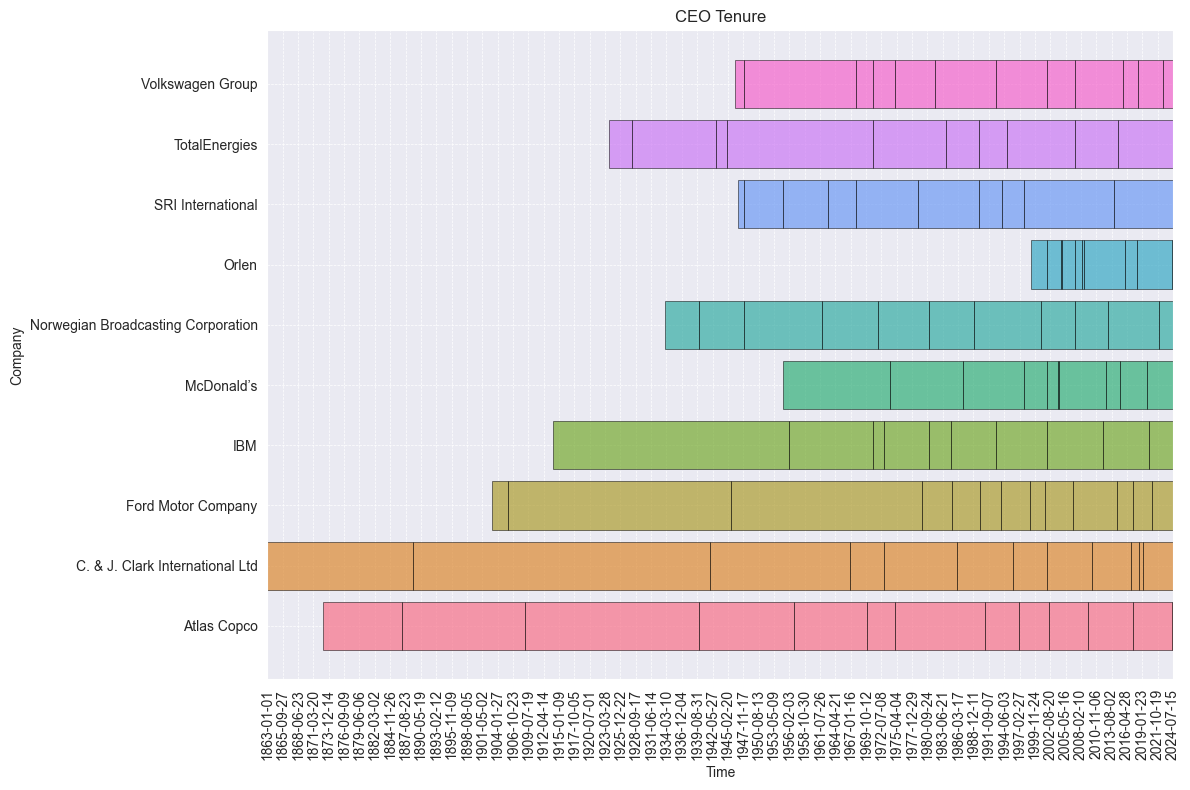

In [11]:
 plot_gantt_chart(most_ceo_changes)#, 'plots/ceo_change_gantt.pdf')

In [12]:
#company_data[company_data['starttime.value']==company_data['starttime.value'].max()]

In [13]:
def get_first_year(company_name):
    df_target = company_data[company_data['company.value']==company_name]
    return df_target['start_year'].min()

def get_last_year(company_name):
    df_target = company_data[company_data['company.value']==company_name]
    return df_target['end_year'].max()

In [14]:
company_data['start_year'] = company_data['starttime.value'].map(lambda x: int(str(x).split('-')[0]))
company_data['end_year'] = company_data['endtime.value'].map(lambda x: int(str(x).split('-')[0]))

company_data['company_first_year'] = company_data['company.value'].apply(get_first_year)
company_data['company_last_year'] = company_data['company.value'].apply(get_last_year)

In [15]:
def num_active_companies(year):
    df_target = company_data[(company_data['company_first_year']<=year) & (company_data['company_last_year']>=year)]
    return df_target.nunique()['company.value']

In [16]:
num_active_companies_per_year = {year: num_active_companies(year)
                                for year in range(company_data['company_first_year'].min(),
                                                 2025)}

In [17]:
num_active_companies_per_year

{1814: 1,
 1815: 1,
 1816: 1,
 1817: 1,
 1818: 1,
 1819: 1,
 1820: 1,
 1821: 1,
 1822: 1,
 1823: 1,
 1824: 1,
 1825: 1,
 1826: 1,
 1827: 1,
 1828: 1,
 1829: 1,
 1830: 1,
 1831: 1,
 1832: 1,
 1833: 1,
 1834: 1,
 1835: 2,
 1836: 2,
 1837: 2,
 1838: 2,
 1839: 2,
 1840: 2,
 1841: 2,
 1842: 2,
 1843: 2,
 1844: 2,
 1845: 2,
 1846: 2,
 1847: 2,
 1848: 2,
 1849: 2,
 1850: 2,
 1851: 2,
 1852: 2,
 1853: 2,
 1854: 2,
 1855: 2,
 1856: 3,
 1857: 3,
 1858: 3,
 1859: 3,
 1860: 3,
 1861: 3,
 1862: 3,
 1863: 4,
 1864: 5,
 1865: 5,
 1866: 5,
 1867: 5,
 1868: 5,
 1869: 6,
 1870: 6,
 1871: 6,
 1872: 6,
 1873: 7,
 1874: 7,
 1875: 7,
 1876: 8,
 1877: 9,
 1878: 9,
 1879: 9,
 1880: 9,
 1881: 9,
 1882: 9,
 1883: 9,
 1884: 9,
 1885: 9,
 1886: 9,
 1887: 9,
 1888: 9,
 1889: 10,
 1890: 11,
 1891: 11,
 1892: 11,
 1893: 11,
 1894: 11,
 1895: 11,
 1896: 11,
 1897: 11,
 1898: 11,
 1899: 11,
 1900: 12,
 1901: 12,
 1902: 13,
 1903: 15,
 1904: 15,
 1905: 16,
 1906: 16,
 1907: 17,
 1908: 17,
 1909: 17,
 1910: 20,
 1911: 2

In [18]:
(1928//10)*10

1920

In [19]:
# See if the acceleration of CEO change over time generalises to all companies in our dataset

# colour=sns.color_palette('husl',n_colors=10)[4]

# Count the number of CEO starts per year
start_years = company_data['start_year'].astype(int)
counts_data = pd.DataFrame(start_years.value_counts().sort_index()).reset_index()
counts_data['rate_new_ceos'] = start_counts.apply(lambda row: 
                                                    row['count']/num_active_companies_per_year[row['start_year']],
                                                   axis=1)
counts_data['num_active_companies']=counts_data['start_year'].map(lambda x: num_active_companies_per_year[x])

counts_data['decade'] = counts_data['start_year'].map(lambda x: str((x //10)*10)+'s')

counts_data_aggregated = counts_data.groupby('decade').aggregate('mean').reset_index()
# Plot the results
fig, ax1 = plt.subplots(figsize=(12,6))
sns.barplot(data = counts_data_aggregated, x='decade', y='rate_new_ceos', alpha=0.5,color='green', ax=ax1)

plt.xticks(ticks=range(0, len(counts_data)), rotation=90) 
plt.xlabel('Decade')
# ax1.set_xlim(1814)
ax2 = ax1.twinx()
sns.lineplot(data = counts_data_aggregated['num_active_companies'], marker='.', alpha=0.8,
             color='purple', ax=ax2)
ax2.set_ylim(0)

# minx, nextx, *_, maxx = ax1.get_xticks() 
# epsx = (nextx - minx) / 1.5  
# ax1.set_xlim(minx-epsx, maxx+epsx)
ax1.set_ylabel('Rate of companies with new CEOs')
ax2.set_ylabel('Number of active companies')

# plt.title('CEO changes per year')

# plt.ylabel('Number of new CEOs divided by number of active companies per year')
# plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# plt.show()
plt.savefig('plots/new_ceos_per_decade.pdf')

NameError: name 'start_counts' is not defined

In [20]:
counts_data_aggregated.reset_index()

NameError: name 'counts_data_aggregated' is not defined

In [21]:
ax2.get_xlim()

NameError: name 'ax2' is not defined

ValueError: Could not interpret value `rate_new_ceos` for `y`. An entry with this name does not appear in `data`.

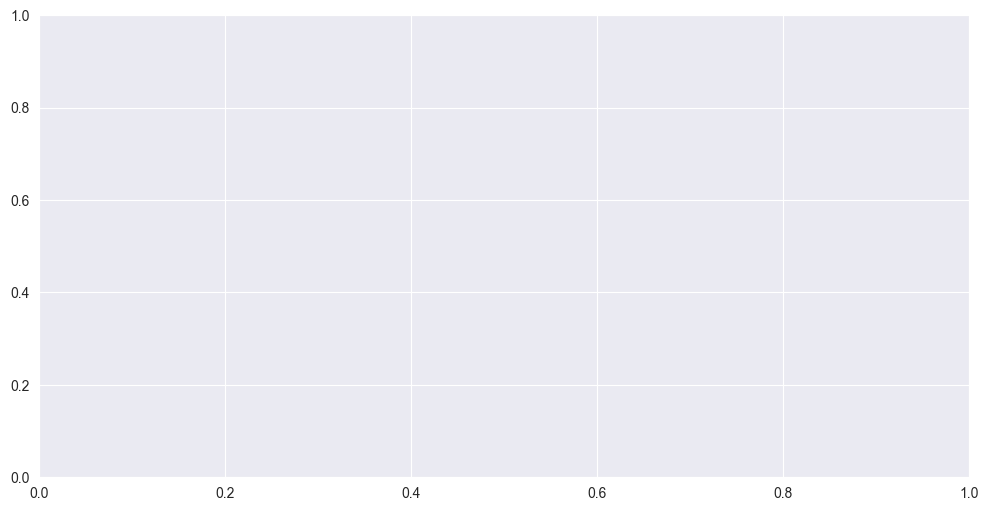

In [22]:
fig, ax1 = plt.subplots(figsize=(12,6))
sns.barplot(data = counts_data, x='start_year', y='rate_new_ceos', alpha=0.5,color='green', ax=ax1)

plt.xticks(ticks=range(0, len(counts_data), 2), rotation=90) 

ax2 = ax1.twinx()
sns.lineplot(data = counts_data['num_active_companies'], marker='o', alpha=0.5,
             color='orange', ax=ax2)
ax2.set_ylim(0)
minx, nextx, *_, maxx = ax1.get_xticks() # same for the x-axis
epsx = (nextx - minx) / 2  
ax1.set_xlim(minx-epsx, maxx+epsx) # nb: different order because the axis is not inverted
 # Show every 2nd year
# plt.xticks(rotation=30)#, ha="right")

In [165]:
# BACKUP

# See if the acceleration of CEO change over time generalises to all companies in our dataset

# colour=sns.color_palette('husl',n_colors=10)[4]

# Count the number of CEO starts per year
start_years = company_data['start_year'].astype(int)
counts_data = pd.DataFrame(start_years.value_counts().sort_index()).reset_index()
counts_data['rate_new_ceos'] = start_counts.apply(lambda row: 
                                                    row['count']/num_active_companies_per_year[row['start_year']],
                                                   axis=1)
counts_data['num_active_companies']=counts_data['start_year'].map(lambda x: num_active_companies_per_year[x])

counts_data['decade'] = counts_data['start_year'].map(lambda x: str((x //10)*10)+'s')


# Plot the results
fig, ax1 = plt.subplots(figsize=(12,6))
sns.barplot(data = counts_data, x='start_year', y='rate_new_ceos', alpha=0.5,color='green', ax=ax1)

plt.xticks(ticks=range(0, len(counts_data), 2), rotation=90) 
plt.xlabel('Year')
# ax1.set_xlim(1814)
ax2 = ax1.twinx()
sns.lineplot(data = counts_data['num_active_companies'], marker='.', alpha=0.7,
             color='purple', ax=ax2)
ax2.set_ylim(0)

minx, nextx, *_, maxx = ax1.get_xticks() # same for the x-axis
epsx = (nextx - minx) / 1.5  
ax1.set_xlim(minx-epsx, maxx+epsx)
ax1.set_ylabel('Rate of companies with new CEOs')
ax2.set_ylabel('Number of active companies')

# plt.title('CEO changes per year')

# plt.ylabel('Number of new CEOs divided by number of active companies per year')
# plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# plt.show()
plt.savefig('plots/new_ceos_per_year_relative.pdf')

,start_year,count,rate_new_ceos,num_active_companies
0,1814,1,1.000000,1
1,1824,1,1.000000,1
2,1835,1,0.500000,2
3,1842,1,0.500000,2
4,1854,1,0.500000,2
...,...,...,...,...
123,2020,96,0.084284,1139
124,2021,68,0.057971,1173
125,2022,56,0.046745,1198
126,2023,60,0.048741,1231


In [152]:
start_counts

,start_year,count,relative_count
0,1814,1,1.000000
1,1824,1,1.000000
2,1835,1,0.500000
3,1842,1,0.500000
4,1854,1,0.500000
...,...,...,...
123,2020,96,0.084284
124,2021,68,0.057971
125,2022,56,0.046745
126,2023,60,0.048741


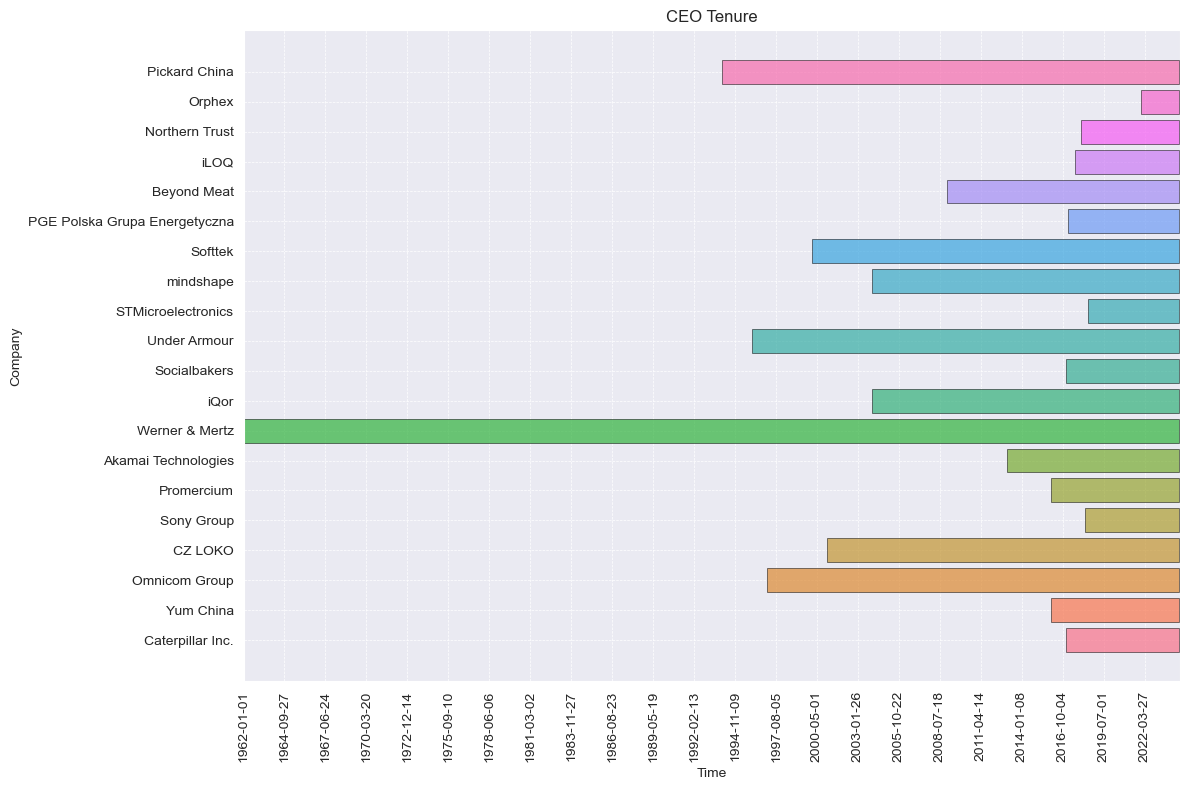

In [243]:
plot_gantt_chart(no_ceo_changes.sample(n=20)) # can't plot them all, there are too many